- 이것이 데이터 분석이다 책 참고
  - 3.2) 비트코인 시세 예측하기
  - https://github.com/yoonkt200/python-data-analysis/blob/master/chapter3/02-coin-prediction.ipynb

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# 데이터

In [2]:
file_path = 'data/train.csv';
df = pd.read_csv(file_path)

## 날짜 + 시간 합친 피처 생성

In [3]:
# 피처를 시계열 피처로 변환
df['날짜'] = df['날짜'].astype(str)
df['날짜'] = pd.to_datetime(df['날짜'])

df['시간'] = pd.to_datetime(df['시간'], format='%H').dt.time

# 날짜와 시간 합쳐서 datetime으로 변경
df['날짜시간'] = pd.to_datetime(df['날짜'].astype(str) + df['시간'].astype(str), format='%Y-%m-%d%H:%M:%S')
df = df.drop(['시간'], axis=1)

In [199]:
df

,날짜,10,100,101,120,121,140,150,160,200,...,1040,1100,1200,1510,2510,3000,4510,5510,6000,날짜시간
0,2020-01-01,83247,19128,2611,5161,1588,892,32263,1636,7938,...,3482,11299,7072,1176,3810,748,3920,2133,3799,2020-01-01 00:00:00
1,2020-01-01,89309,19027,3337,5502,1650,1043,35609,1644,9896,...,3849,13180,8771,1283,3763,782,3483,2057,4010,2020-01-01 01:00:00
2,2020-01-01,66611,14710,2970,4631,1044,921,26821,1104,9343,...,2299,7986,5426,1536,3229,491,2634,1526,3388,2020-01-01 02:00:00
3,2020-01-01,53290,13753,2270,4242,1021,790,21322,909,10009,...,1716,5703,3156,1104,2882,431,2488,1268,3686,2020-01-01 03:00:00
4,2020-01-01,52095,17615,2406,3689,1840,922,22711,1354,15497,...,2421,5816,2933,1206,2433,499,2952,1927,5608,2020-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,2020-05-17,311727,101285,10085,30637,10060,8749,148935,6801,26101,...,15431,25597,14292,9300,22238,3786,16936,10729,20194,2020-05-17 19:00:00
3308,2020-05-17,305354,91426,8607,26021,8095,7198,136503,6147,20759,...,15378,24661,14747,8239,20604,3203,15018,9767,17962,2020-05-17 20:00:00
3309,2020-05-17,306008,75113,6325,19933,5711,4494,129412,5134,14496,...,12558,22781,14081,6392,17937,2447,12403,7825,14031,2020-05-17 21:00:00
3310,2020-05-17,237447,49498,4209,12145,3891,2718,96698,3526,9363,...,8870,16640,11066,4427,11955,1495,7507,5387,8889,2020-05-17 22:00:00


In [173]:
# # 날짜를 index로 설정, 시간은 포함ㄴㄴ
# sh = df.copy()

# sh.index = sh['날짜']
# sh.set_index('날짜', inplace=True)
# sh = ari[['10']]
# sh = sh.rename(columns={'10' : '경부선'})
# sh

,경부선
날짜,
2020-01-01 00:00:00,83247
2020-01-01 01:00:00,89309
2020-01-01 02:00:00,66611
2020-01-01 03:00:00,53290
2020-01-01 04:00:00,52095
...,...
2020-05-17 19:00:00,311727
2020-05-17 20:00:00,305354
2020-05-17 21:00:00,306008


# [Facebook Prophet 활용하기]
https://zzsza.github.io/data/2019/02/06/prophet/

- prophet의 input data columns는 'ds'와 'y'로 고정되어야 함
- seasonality_mode : 연간, 월간, 주간, 일간 등의 트렌드성을 반영하는 것을 의미
- hangepoint_prior_scale : 트렌드가 변경되는 문맥을 반영하여 예측. 수치가 높을수록 overfitting에 가까워짐.

In [4]:
from fbprophet import Prophet

### 입력 데이터 준비

In [204]:
df.head(1)

,날짜,10,100,101,120,121,140,150,160,200,...,1040,1100,1200,1510,2510,3000,4510,5510,6000,날짜시간
0,2020-01-01,83247,19128,2611,5161,1588,892,32263,1636,7938,...,3482,11299,7072,1176,3810,748,3920,2133,3799,2020-01-01


In [5]:
date = df.iloc[:,:2]
time = df.iloc[:,[1,-1]]

In [6]:
# prophet을 사용하기 위해서는 다음과 같이 피처의 이름을 변경해야 함 : 'ds', 'y'
date.columns=['ds','y']
date = date.groupby("ds").sum()
date.reset_index(level=0, inplace=True)

time = time[['날짜시간','10']]
time.columns = ['ds','y']

# 모델

In [7]:
INPUT_DATA = time

In [8]:
prophet = Prophet(seasonality_mode='additive',  # multiplicative
                  yearly_seasonality=True,
                  weekly_seasonality=True, 
                  daily_seasonality=True,
                  # add_country_holidays=(country_name:KR), # ??
                  # holidays=holidays,
                  changepoint_prior_scale=0.05)

prophet.add_country_holidays(country_name='KR')

prophet.fit(INPUT_DATA)

Initial log joint probability = -142.452


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7468.44    0.00727454       288.662      0.7339      0.7339      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7480.52    0.00540829       412.283       0.483       0.483      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7493.29     0.0016736       199.876      0.2722      0.8441      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7499.62     0.0105465       210.468     0.09407           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     400       7499.64   0.000211921       278.707   1.007e-06       0.001      488  LS failed, Hessian reset 
     499       7500.49   2.43121e-07        101.57      0.2216           1      6

## 예측할 기간을 정의하고, 결과를 도출 

In [12]:
24*7

168

In [13]:
future_data = prophet.make_future_dataframe(periods=168, freq='H')  # 7일을 내다보며 예측  # 날짜별 'd', 시간대별 'h'
forecast_data = prophet.predict(future_data)

In [14]:
future_data.tail(30)

,ds
3450,2020-05-23 18:00:00
3451,2020-05-23 19:00:00
3452,2020-05-23 20:00:00
3453,2020-05-23 21:00:00
3454,2020-05-23 22:00:00
3455,2020-05-23 23:00:00
3456,2020-05-24 00:00:00
3457,2020-05-24 01:00:00
3458,2020-05-24 02:00:00
3459,2020-05-24 03:00:00


In [15]:
forecast_data.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Lunar New Year's Day,Alternative holiday of Lunar New Year's Day_lower,Alternative holiday of Lunar New Year's Day_upper,Alternative public holiday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3450,2020-05-23 18:00:00,536272.865195,445455.437829,537827.306828,536270.625607,536274.858004,0.0,0.0,0.0,0.0,...,-20961.183188,-20961.183188,-20961.183188,-123602.331414,-123602.331414,-123602.331414,0.0,0.0,0.0,492458.912621
3451,2020-05-23 19:00:00,536330.655303,402613.424307,504494.464937,536328.387732,536332.668884,0.0,0.0,0.0,0.0,...,-22959.399961,-22959.399961,-22959.399961,-121648.896472,-121648.896472,-121648.896472,0.0,0.0,0.0,453718.501451
3452,2020-05-23 20:00:00,536388.445411,359766.203900,458251.833073,536386.158453,536390.480509,0.0,0.0,0.0,0.0,...,-24751.188254,-24751.188254,-24751.188254,-119682.176595,-119682.176595,-119682.176595,0.0,0.0,0.0,409373.719844
3453,2020-05-23 21:00:00,536446.235519,319828.433090,413347.058130,536443.930485,536448.301358,0.0,0.0,0.0,0.0,...,-26320.567437,-26320.567437,-26320.567437,-117702.151330,-117702.151330,-117702.151330,0.0,0.0,0.0,366617.058107
3454,2020-05-23 22:00:00,536504.025627,275529.087338,373623.975733,536501.680188,536506.123723,0.0,0.0,0.0,0.0,...,-27653.869994,-27653.869994,-27653.869994,-115708.800612,-115708.800612,-115708.800612,0.0,0.0,0.0,327814.334933
3455,2020-05-23 23:00:00,536561.815735,241918.942508,337558.271209,536559.430256,536563.959796,0.0,0.0,0.0,0.0,...,-28739.892514,-28739.892514,-28739.892514,-113702.104764,-113702.104764,-113702.104764,0.0,0.0,0.0,290837.493098
3456,2020-05-24 00:00:00,536619.605843,207057.356615,301425.613663,536617.212180,536621.795522,0.0,0.0,0.0,0.0,...,-29570.018471,-29570.018471,-29570.018471,-111682.044501,-111682.044501,-111682.044501,0.0,0.0,0.0,253867.573233
3457,2020-05-24 01:00:00,536677.395951,173916.766931,270124.944622,536675.003510,536679.630439,0.0,0.0,0.0,0.0,...,-30138.311353,-30138.311353,-30138.311353,-109648.600932,-109648.600932,-109648.600932,0.0,0.0,0.0,220620.412542
3458,2020-05-24 02:00:00,536735.186059,157124.342492,246947.196463,536732.783835,536737.451252,0.0,0.0,0.0,0.0,...,-30441.577015,-30441.577015,-30441.577015,-107601.755561,-107601.755561,-107601.755561,0.0,0.0,0.0,201126.134024
3459,2020-05-24 03:00:00,536792.976167,159817.618550,252954.779453,536790.548921,536795.262791,0.0,0.0,0.0,0.0,...,-30479.394539,-30479.394539,-30479.394539,-105541.490293,-105541.490293,-105541.490293,0.0,0.0,0.0,206606.415306


In [16]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
3475,2020-05-24 19:00:00,524757.443729,479117.513053,572347.951219
3476,2020-05-24 20:00:00,484835.298624,441075.743782,532614.986782
3477,2020-05-24 21:00:00,446213.587044,399260.397453,492554.608972
3478,2020-05-24 22:00:00,411221.484183,366899.982787,458291.734096
3479,2020-05-24 23:00:00,377698.051302,330702.737056,424503.550180


# 결과 시각화
- 검은 점 : 훈련에 사용했던 데이터
- 예측 : 진한 파란 선

### 전체 데이터를 기반으로 학습한, 7일 단위의 예측 결과를 시각화

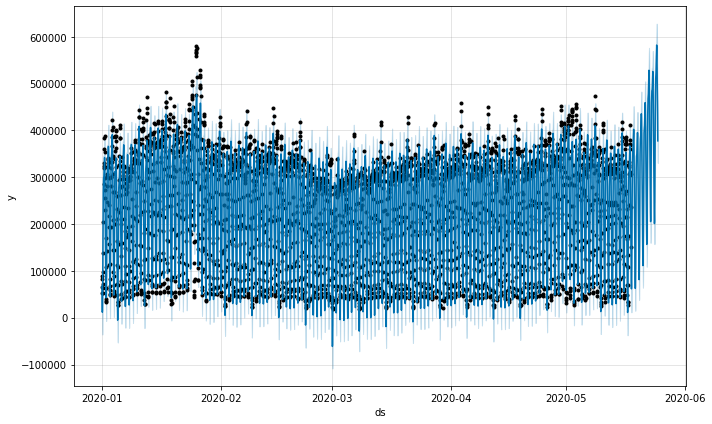

In [17]:
fig1 = prophet.plot(forecast_data)

### seasonality_mode로 설정했었던 기간별 트렌드 정보를 시각화

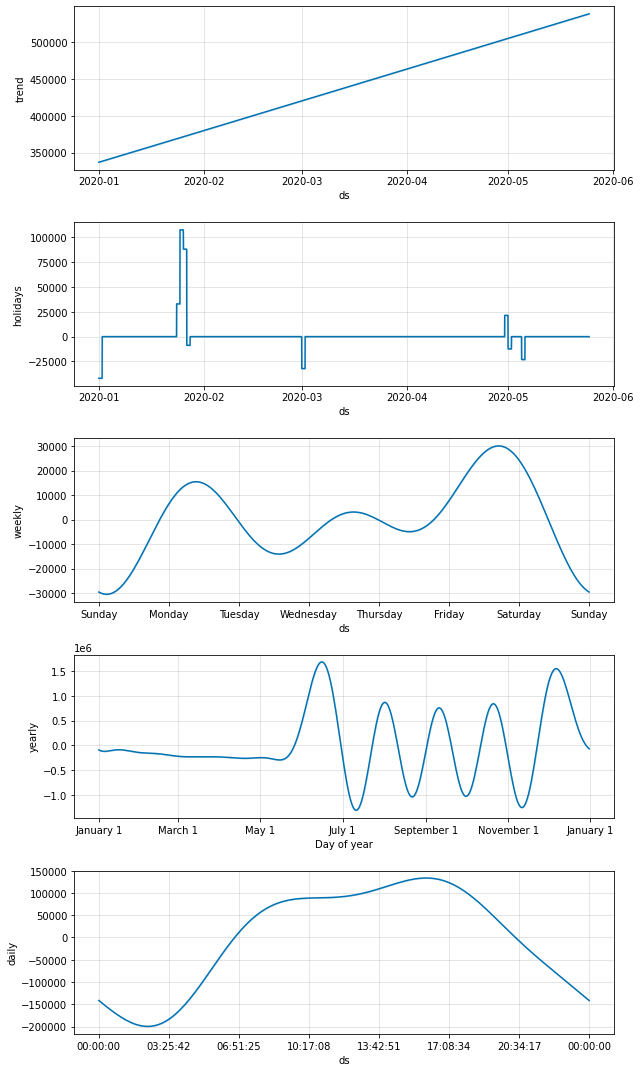

In [18]:
fig2 = prophet.plot_components(forecast_data)

# 모델 성능
실제 교통량과 예측한 교통량의 차이 : 첫 5일과 마지막 5일은 제외하고 계산

In [20]:
y = INPUT_DATA.y.values[168:] # 첫 7일을 제외한 실제 교통량 데이터
y_pred = forecast_data.yhat.values[168:-168] # 첫 7일, 마지막 7일을 제외한 예측 데이터

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(rmse)
print(r2)

36403.58203416877
0.9106150489354179
